In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# Load dicom dataframe
df = pd.read_feather('../../1_Data_Extraction/Data/dicom_df_0.feather')
df.head()

,Dicomdir,PatientId,StudyId,SeriesId,AccessionNumber,AcquisitionDate,AcquisitionDateTime,AcquisitionNumber,AcquisitionTime,AdmittingDiagnosesDescription,...,OverlayColumns,OverlayData,OverlayDescription,OverlayOrigin,OverlayRows,OverlayType,PatientComments,NameOfPhysiciansReadingStudy,EthnicGroup,PatientState
0,..\..\Scans\2022-01\DICOMDIR,ANONYM-XT8UJZ,1.2.40.0.13.1.31351380426905905351292839561978...,1.2.40.0.13.1.70506743092902795655309425996746...,GLKQKZDGQZGOZJX,20210610,151635.794,2,151635.794,,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
1,..\..\Scans\2022-01\DICOMDIR,ANONYM-XT8UJZ_1,1.2.40.0.13.1.17673763456969116914244798980205...,1.2.40.0.13.1.22199141000052275677980158947820...,QQCKBCDCAIJNUQI,20190221,184011.010,2,184011.000,,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
2,..\..\Scans\2022-01\DICOMDIR,ANONYM-XT8UJZ_2,1.2.40.0.13.1.16621219697005344268574789979711...,1.2.40.0.13.1.79080220071392034037718776900243...,PPCTFYIKTTTMOHC,20180314,233409.248,2,233409.248,,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
3,..\..\Scans\2022-01\DICOMDIR,ANONYM-XT8UJZ_3,1.2.40.0.13.1.16932927470742447813201714735294...,1.2.40.0.13.1.44600102249142374796035333831945...,KTJTLMCRRPPUONF,20211012,124143.010,1,124143.000,,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
4,..\..\Scans\2022-01\DICOMDIR,ANONYM-XT8UJZ_3,1.2.40.0.13.1.29987579509307136339818887016894...,1.2.40.0.13.1.33620446475559136671173278433456...,KTJTLMCRRPPUONF,20211012,125518.010,1,125518.000,,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None


In [4]:
# Get pixel arrays, weights and dimensions from dataframe
pixel_arrays = df['PixelArrayFlat'].values
patient_weights = df['PatientWeight'].values
dimensions = df[['SliceCount','Rows', 'Columns']]

In [5]:
pixel_arrays[0].shape

(127664128,)

In [6]:
# Reshape pixel arrays to 3D arrays
pixel_arrays = [pa.reshape(dimensions.iloc[i]) for i, pa in enumerate(pixel_arrays)]
pixel_arrays[0].shape

(487, 512, 512)

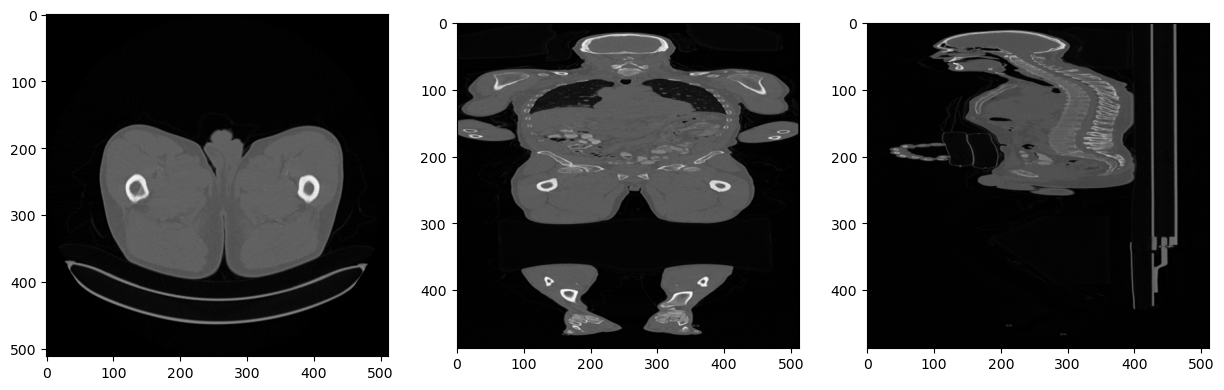

In [7]:
# plot mid point planes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(pixel_arrays[0][dimensions.iloc[0,0]//2], cmap='gray')
axs[1].imshow(pixel_arrays[0][:,dimensions.iloc[0,1]//2], cmap='gray')
axs[2].imshow(pixel_arrays[0][:,:,dimensions.iloc[0,2]//2], cmap='gray')
plt.show()

In [8]:
# get all mid point planes
axial = [pa[pa.shape[0]//2] for pa in pixel_arrays]

In [9]:
# to numpy array
axial = np.array(axial)
axial.shape

(100, 512, 512)

In [10]:
# To tensor
axial = torch.tensor(axial, device='cpu', dtype=torch.float32)
axial.shape

torch.Size([100, 512, 512])

In [11]:
# add channel dimension
axial = axial.unsqueeze(1)
axial.shape

torch.Size([100, 1, 512, 512])

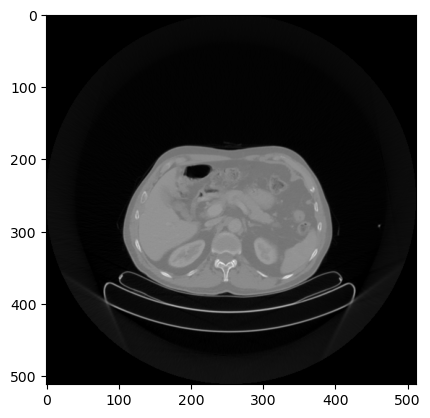

In [12]:
# plot first image
plt.imshow(axial[1,0], cmap='gray')
plt.show()

In [13]:
# apply resnet 18 transforms
# ResNet-18 expects 3 channels (RGB), so we need to convert our single channel to 3 channels by repeating it
from torchvision import transforms

resnet_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat channel to get 3 channels
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # to tensor not needed as we already have tensor -> maybe previous steps can be done here?
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
# Apply the transformation
data_tensor = torch.stack([resnet_transform(img) for img in axial])

In [15]:
 # Load the pre-trained model
from torchvision import models
from torchvision.models.resnet import ResNet18_Weights

resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# replace fully connected layer with regression layer
resnet18.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

In [17]:
# Forward pass
with torch.no_grad():
    outputs = resnet18(data_tensor)

print(outputs)

tensor([[-0.6663],
        [-0.4714],
        [-0.8041],
        [-0.9128],
        [-0.4299],
        [-0.3869],
        [-0.3172],
        [-0.4853],
        [-0.3441],
        [-0.0342],
        [-0.2690],
        [-0.3603],
        [-0.5446],
        [-0.4931],
        [-0.2226],
        [-0.2620],
        [-0.6075],
        [-0.5054],
        [-0.2391],
        [-0.8022],
        [-0.2306],
        [-0.7396],
        [-0.2936],
        [-0.7628],
        [-0.6854],
        [-0.3140],
        [-0.6671],
        [-0.4224],
        [-0.7788],
        [-0.5584],
        [-0.3369],
        [-0.3897],
        [-0.6919],
        [-0.4903],
        [-0.8329],
        [-0.4552],
        [-0.6161],
        [-0.4100],
        [-0.0924],
        [-0.4663],
        [-0.0332],
        [-0.7017],
        [-0.2266],
        [-0.4237],
        [-0.4716],
        [-1.3425],
        [-0.1776],
        [-0.7791],
        [-0.4025],
        [ 0.0552],
        [-0.5188],
        [-0.1398],
        [-0.